In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

from sklearn.model_selection import StratifiedGroupKFold

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])
text_cols = ["LudRules",]

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))
print("Text features:", len(text_cols))

Numerical features: 296
Categorical features: 5
Text features: 1


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 368
Categorical Columns: 5


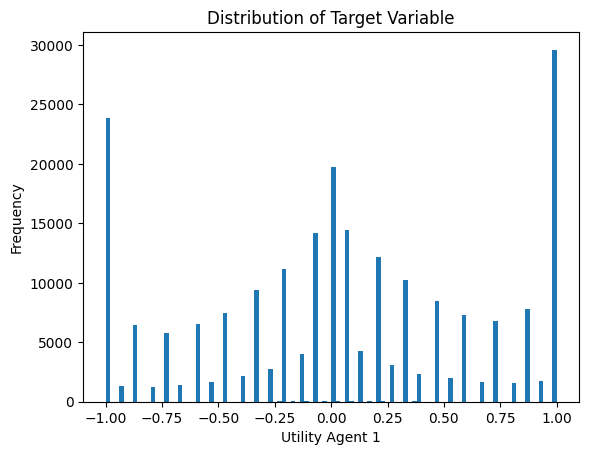

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model

In [6]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [7]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        num_folds=5,
        cv_random_state=2112,
    ):
    # Define the number of folds for cross-validation
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=num_folds, random_state=cv_random_state, shuffle=True)
    split_list = gkf.split(df_train, groups=df_train[group_col], y=df_train[y_col])

    # Define the parameters for CatBoost
    params = {
        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }

        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        plot_feature_importance(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1
0:	learn: 0.6031503	test: 0.6051224	best: 0.6051224 (0)	total: 125ms	remaining: 6m 13s
50:	learn: 0.3955390	test: 0.4487064	best: 0.4487064 (50)	total: 4.21s	remaining: 4m 3s
100:	learn: 0.3581313	test: 0.4324247	best: 0.4324247 (100)	total: 8.29s	remaining: 3m 57s
150:	learn: 0.3375880	test: 0.4257468	best: 0.4257468 (150)	total: 12.4s	remaining: 3m 54s
200:	learn: 0.3231251	test: 0.4215327	best: 0.4215170 (199)	total: 16.4s	remaining: 3m 47s
250:	learn: 0.3120682	test: 0.4184567	best: 0.4184567 (250)	total: 20.1s	remaining: 3m 40s
300:	learn: 0.3036331	test: 0.4174338	best: 0.4173820 (296)	total: 24.1s	remaining: 3m 35s
350:	learn: 0.2965693	test: 0.4159763	best: 0.4159763 (350)	total: 27.9s	remaining: 3m 30s
400:	learn: 0.2905639	test: 0.4147970	best: 0.4147970 (400)	total: 31.8s	remaining: 3m 26s
450:	learn: 0.2848337	test: 0.4139148	best: 0.4139148 (450)	total: 35.7s	remaining: 3m 22s
500:	learn: 0.2796361	test: 0.4127393	best: 0.4127393 (500)	total: 39.6s	remaining: 3m 17s

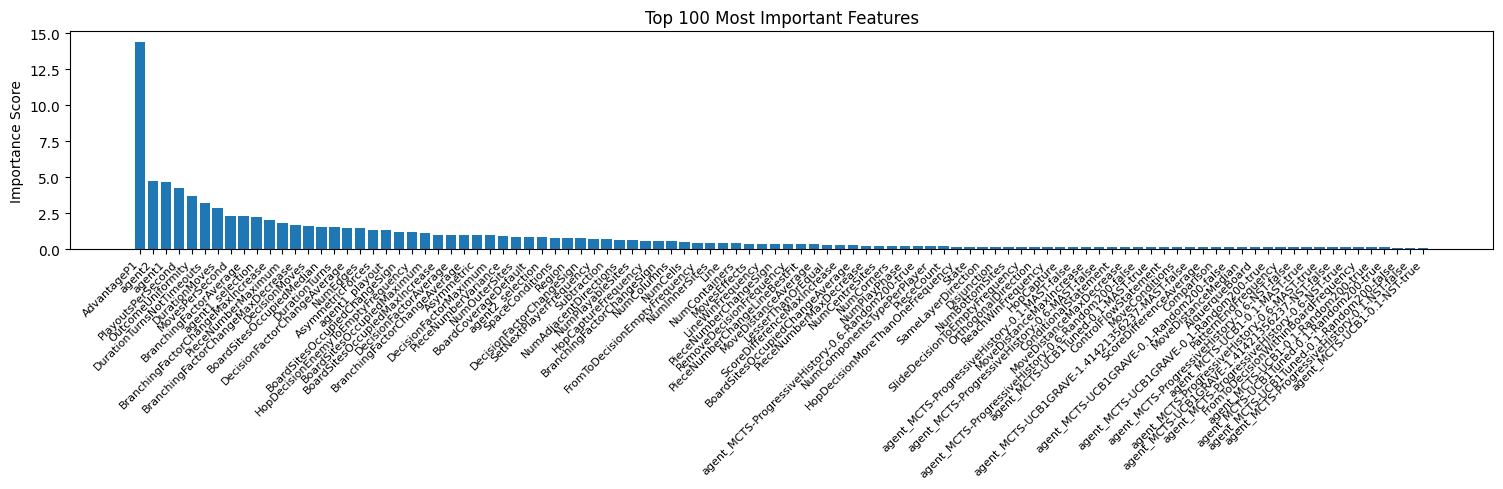

Fold 1 - RMSE: 0.4047069075852309
Fold 2
0:	learn: 0.5982384	test: 0.6161155	best: 0.6161155 (0)	total: 67ms	remaining: 3m 21s
50:	learn: 0.3866743	test: 0.4841534	best: 0.4841534 (50)	total: 3.69s	remaining: 3m 33s
100:	learn: 0.3521863	test: 0.4714673	best: 0.4713903 (99)	total: 7.49s	remaining: 3m 35s
150:	learn: 0.3328935	test: 0.4667446	best: 0.4667446 (150)	total: 11.2s	remaining: 3m 30s
200:	learn: 0.3201846	test: 0.4639612	best: 0.4639213 (194)	total: 15.1s	remaining: 3m 30s
250:	learn: 0.3099826	test: 0.4615926	best: 0.4615926 (250)	total: 18.9s	remaining: 3m 27s
300:	learn: 0.3018703	test: 0.4603569	best: 0.4603569 (300)	total: 23s	remaining: 3m 25s
350:	learn: 0.2948625	test: 0.4594924	best: 0.4594924 (350)	total: 26.8s	remaining: 3m 22s
400:	learn: 0.2885394	test: 0.4582307	best: 0.4582307 (400)	total: 30.7s	remaining: 3m 19s
450:	learn: 0.2829958	test: 0.4575306	best: 0.4575306 (450)	total: 34.6s	remaining: 3m 15s
500:	learn: 0.2781420	test: 0.4565702	best: 0.4565702 (500)

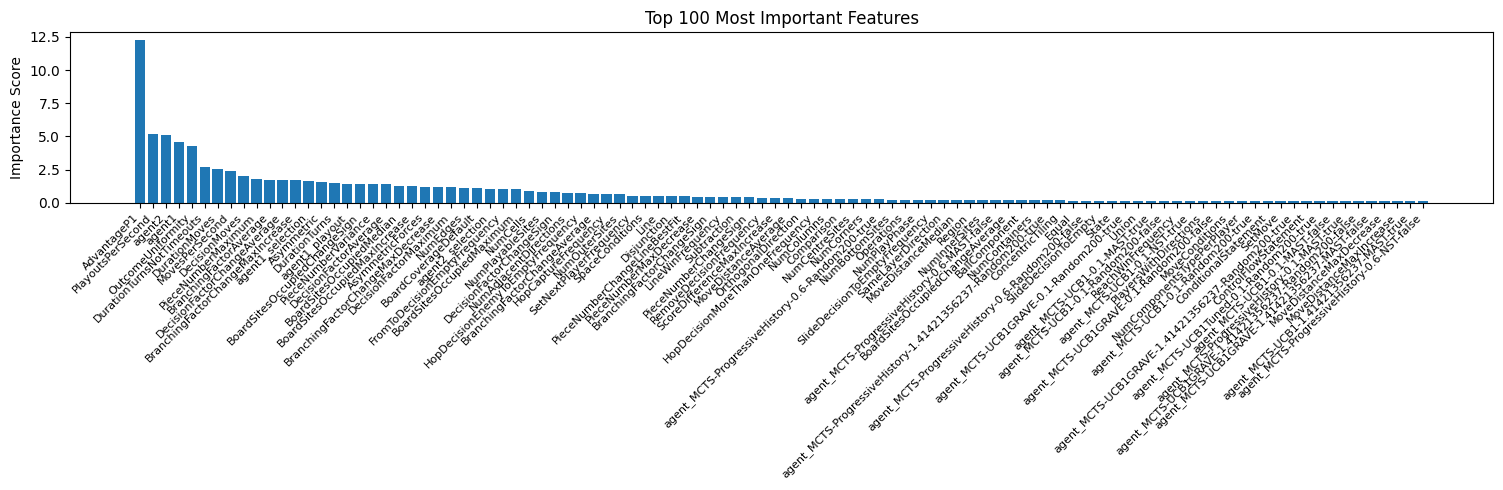

Fold 2 - RMSE: 0.44709937398864297
Fold 3
0:	learn: 0.6062662	test: 0.5856109	best: 0.5856109 (0)	total: 76.7ms	remaining: 3m 49s
50:	learn: 0.3935427	test: 0.4513280	best: 0.4513280 (50)	total: 3.83s	remaining: 3m 41s
100:	learn: 0.3570006	test: 0.4350941	best: 0.4350941 (100)	total: 7.8s	remaining: 3m 43s
150:	learn: 0.3374979	test: 0.4263474	best: 0.4263474 (150)	total: 11.8s	remaining: 3m 43s
200:	learn: 0.3231782	test: 0.4218285	best: 0.4217016 (197)	total: 15.8s	remaining: 3m 39s
250:	learn: 0.3123576	test: 0.4193268	best: 0.4193268 (250)	total: 19.8s	remaining: 3m 36s
300:	learn: 0.3033156	test: 0.4166723	best: 0.4166723 (300)	total: 23.9s	remaining: 3m 34s
350:	learn: 0.2952687	test: 0.4147719	best: 0.4147324 (349)	total: 27.9s	remaining: 3m 30s
400:	learn: 0.2886134	test: 0.4139073	best: 0.4139021 (398)	total: 32s	remaining: 3m 27s
450:	learn: 0.2829870	test: 0.4129414	best: 0.4129275 (448)	total: 36.2s	remaining: 3m 24s
500:	learn: 0.2780914	test: 0.4118542	best: 0.4118542 (5

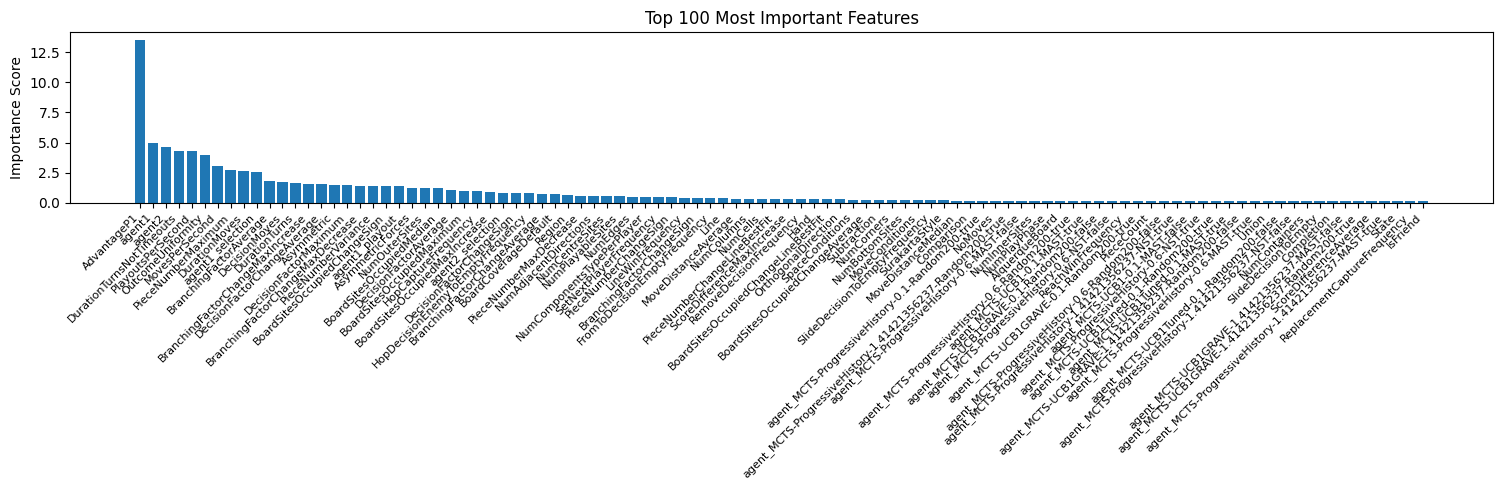

Fold 3 - RMSE: 0.40462555515518234
Fold 4
0:	learn: 0.5991837	test: 0.6171679	best: 0.6171679 (0)	total: 63.1ms	remaining: 3m 9s
50:	learn: 0.3908161	test: 0.4656782	best: 0.4656782 (50)	total: 3.9s	remaining: 3m 45s
100:	learn: 0.3571591	test: 0.4475628	best: 0.4475628 (100)	total: 8.11s	remaining: 3m 52s
150:	learn: 0.3375831	test: 0.4388188	best: 0.4388188 (150)	total: 12.3s	remaining: 3m 51s
200:	learn: 0.3240808	test: 0.4347038	best: 0.4347038 (200)	total: 16.4s	remaining: 3m 48s
250:	learn: 0.3132948	test: 0.4306571	best: 0.4306571 (250)	total: 20.5s	remaining: 3m 45s
300:	learn: 0.3048247	test: 0.4282353	best: 0.4282353 (300)	total: 24.8s	remaining: 3m 42s
350:	learn: 0.2977326	test: 0.4261287	best: 0.4261287 (350)	total: 29s	remaining: 3m 38s
400:	learn: 0.2913896	test: 0.4245708	best: 0.4244895 (397)	total: 33.2s	remaining: 3m 35s
450:	learn: 0.2857369	test: 0.4231295	best: 0.4231295 (450)	total: 37.5s	remaining: 3m 31s
500:	learn: 0.2803713	test: 0.4218889	best: 0.4218852 (49

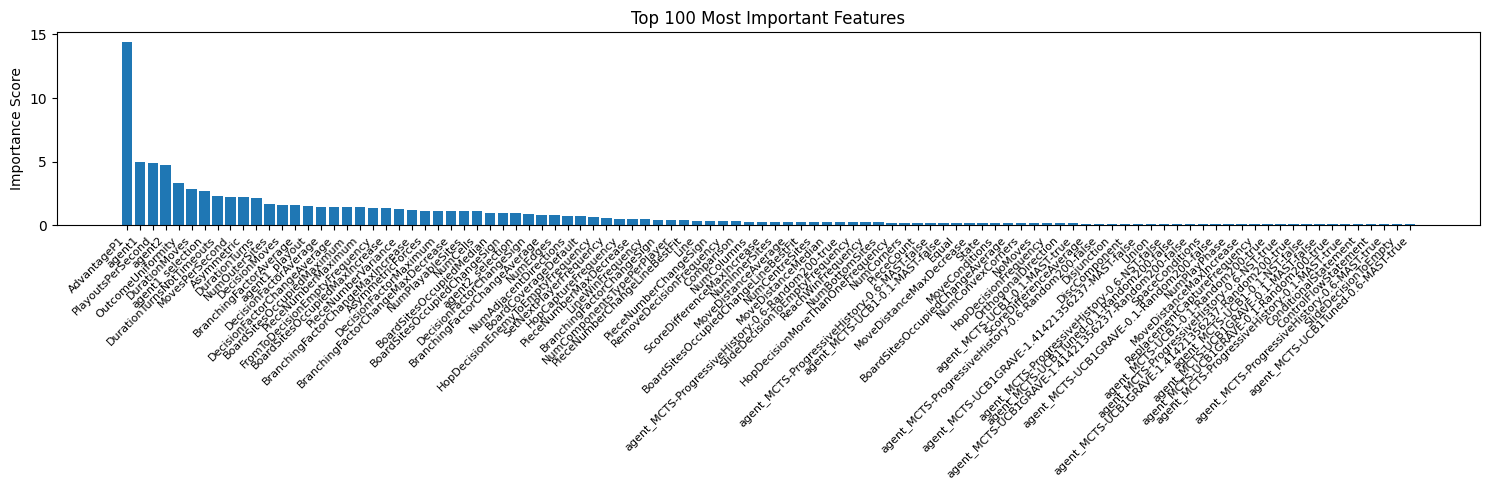

Fold 4 - RMSE: 0.4098553657602444
Fold 5
0:	learn: 0.6005189	test: 0.6131573	best: 0.6131573 (0)	total: 74.1ms	remaining: 3m 42s
50:	learn: 0.3951078	test: 0.4712765	best: 0.4712499 (49)	total: 4.01s	remaining: 3m 52s
100:	learn: 0.3590759	test: 0.4545469	best: 0.4545463 (98)	total: 8.14s	remaining: 3m 53s
150:	learn: 0.3380834	test: 0.4480508	best: 0.4479890 (149)	total: 12.2s	remaining: 3m 49s
200:	learn: 0.3247216	test: 0.4443982	best: 0.4443982 (200)	total: 16.2s	remaining: 3m 45s
250:	learn: 0.3145317	test: 0.4420876	best: 0.4420852 (249)	total: 20.4s	remaining: 3m 43s
300:	learn: 0.3058814	test: 0.4402839	best: 0.4402839 (300)	total: 24.5s	remaining: 3m 40s
350:	learn: 0.2984596	test: 0.4389796	best: 0.4389782 (347)	total: 28.7s	remaining: 3m 36s
400:	learn: 0.2922992	test: 0.4380752	best: 0.4380752 (400)	total: 32.9s	remaining: 3m 32s
450:	learn: 0.2862116	test: 0.4368807	best: 0.4368636 (442)	total: 37s	remaining: 3m 28s
500:	learn: 0.2808729	test: 0.4355974	best: 0.4355892 (49

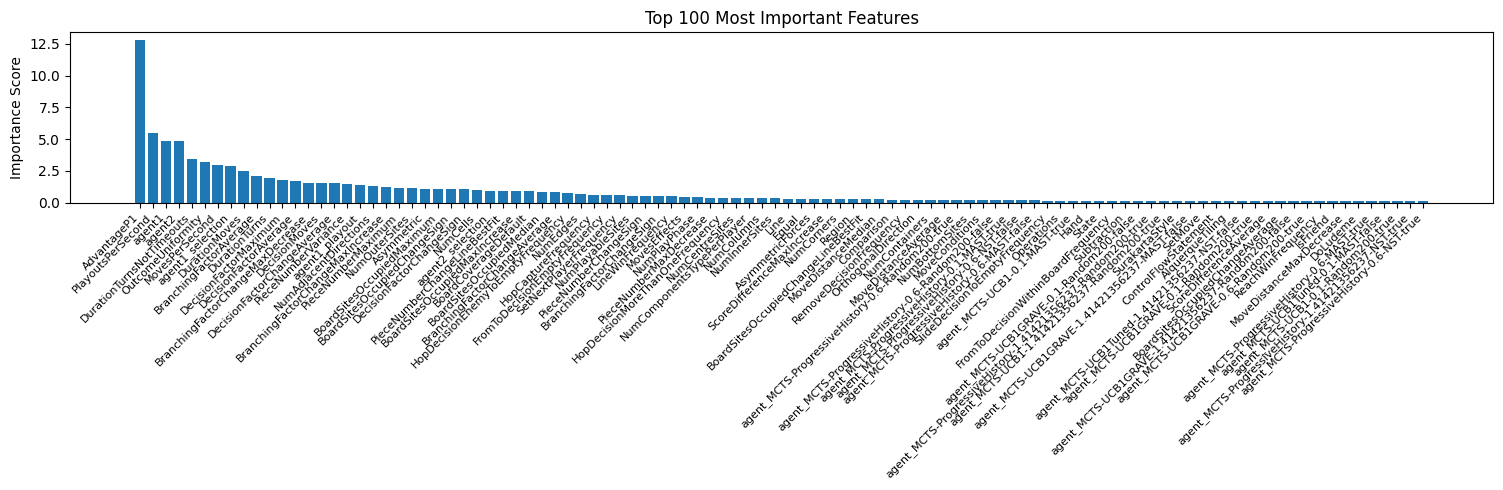

Fold 5 - RMSE: 0.4283372260020486
List of oof scores: [0.4047069075852309, 0.44709937398864297, 0.40462555515518234, 0.4098553657602444, 0.4283372260020486]
Average oof score: 0.4189248856982698


In [8]:
# call the function
trained_models1, oof1, oof_scores1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    num_folds=5,
    cv_random_state=2112,
)
# save oof predictions
oof1.to_csv(path_results / 'oof_catboost_cv1.csv', index=False)

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1
0:	learn: 0.6023434	test: 0.6008672	best: 0.6008672 (0)	total: 61.4ms	remaining: 3m 4s
50:	learn: 0.3953940	test: 0.4662502	best: 0.4662502 (50)	total: 3.9s	remaining: 3m 45s
100:	learn: 0.3567345	test: 0.4478213	best: 0.4478213 (100)	total: 7.99s	remaining: 3m 49s
150:	learn: 0.3370819	test: 0.4409822	best: 0.4409822 (150)	total: 11.9s	remaining: 3m 43s
200:	learn: 0.3244746	test: 0.4371407	best: 0.4371407 (200)	total: 15.9s	remaining: 3m 41s
250:	learn: 0.3142002	test: 0.4340101	best: 0.4340101 (250)	total: 20s	remaining: 3m 39s
300:	learn: 0.3052595	test: 0.4316754	best: 0.4316064 (297)	total: 24.2s	remaining: 3m 36s
350:	learn: 0.2979771	test: 0.4303144	best: 0.4302464 (347)	total: 28.7s	remaining: 3m 36s
400:	learn: 0.2920054	test: 0.4289958	best: 0.4289958 (400)	total: 32.8s	remaining: 3m 32s
450:	learn: 0.2866192	test: 0.4281638	best: 0.4281638 (450)	total: 36.9s	remaining: 3m 28s
500:	learn: 0.2817987	test: 0.4268004	best: 0.4268004 (500)	total: 41.2s	remaining: 3m 25s
5

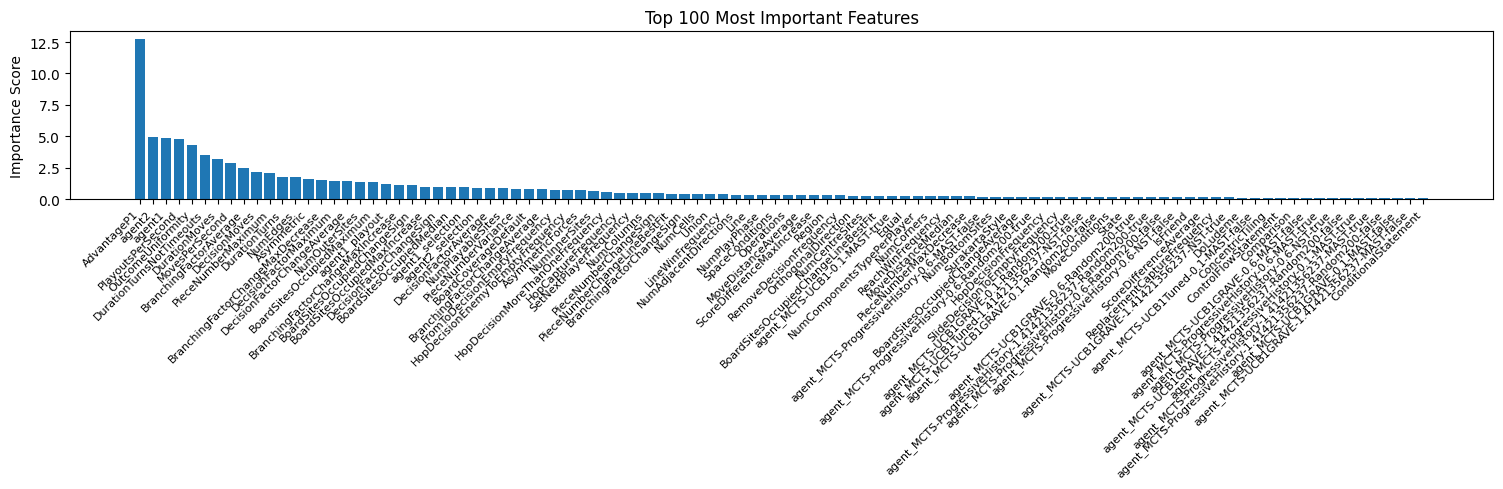

Fold 1 - RMSE: 0.4183308778024541
Fold 2
0:	learn: 0.5972810	test: 0.6174193	best: 0.6174193 (0)	total: 72.8ms	remaining: 3m 38s
50:	learn: 0.3918847	test: 0.4708622	best: 0.4708622 (50)	total: 3.87s	remaining: 3m 43s
100:	learn: 0.3566257	test: 0.4552740	best: 0.4552740 (100)	total: 8.27s	remaining: 3m 57s
150:	learn: 0.3355858	test: 0.4482316	best: 0.4481925 (149)	total: 12.5s	remaining: 3m 55s
200:	learn: 0.3223085	test: 0.4452047	best: 0.4452047 (200)	total: 16.6s	remaining: 3m 51s
250:	learn: 0.3119257	test: 0.4435528	best: 0.4435528 (250)	total: 20.8s	remaining: 3m 47s
300:	learn: 0.3030528	test: 0.4413728	best: 0.4413728 (300)	total: 24.9s	remaining: 3m 43s
350:	learn: 0.2958046	test: 0.4398420	best: 0.4398420 (350)	total: 29.1s	remaining: 3m 39s
400:	learn: 0.2889483	test: 0.4385362	best: 0.4385362 (400)	total: 33.3s	remaining: 3m 35s
450:	learn: 0.2829014	test: 0.4377282	best: 0.4377123 (448)	total: 37.5s	remaining: 3m 32s
500:	learn: 0.2776439	test: 0.4369156	best: 0.4369156 

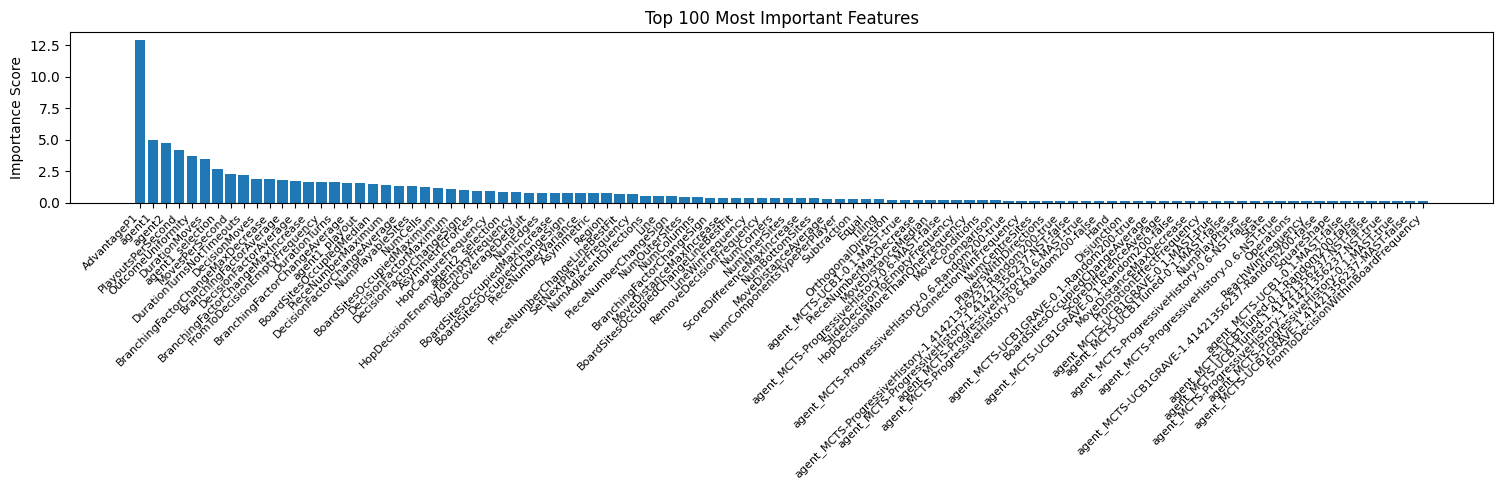

Fold 2 - RMSE: 0.4311202587386601
Fold 3
0:	learn: 0.6055285	test: 0.5846831	best: 0.5846831 (0)	total: 75.9ms	remaining: 3m 47s
50:	learn: 0.3933305	test: 0.4714496	best: 0.4714496 (50)	total: 4.03s	remaining: 3m 53s
100:	learn: 0.3542819	test: 0.4552884	best: 0.4552884 (100)	total: 8.34s	remaining: 3m 59s
150:	learn: 0.3350017	test: 0.4496424	best: 0.4493992 (147)	total: 12.6s	remaining: 3m 57s
200:	learn: 0.3204174	test: 0.4453011	best: 0.4453011 (200)	total: 16.8s	remaining: 3m 53s
250:	learn: 0.3093295	test: 0.4426253	best: 0.4426253 (250)	total: 21s	remaining: 3m 50s
300:	learn: 0.3008734	test: 0.4412279	best: 0.4412163 (297)	total: 25.3s	remaining: 3m 46s
350:	learn: 0.2934484	test: 0.4398215	best: 0.4397820 (348)	total: 29.5s	remaining: 3m 42s
400:	learn: 0.2873955	test: 0.4385003	best: 0.4385003 (400)	total: 33.9s	remaining: 3m 39s
450:	learn: 0.2820985	test: 0.4379055	best: 0.4379055 (450)	total: 38.2s	remaining: 3m 35s
500:	learn: 0.2771483	test: 0.4368430	best: 0.4368430 (5

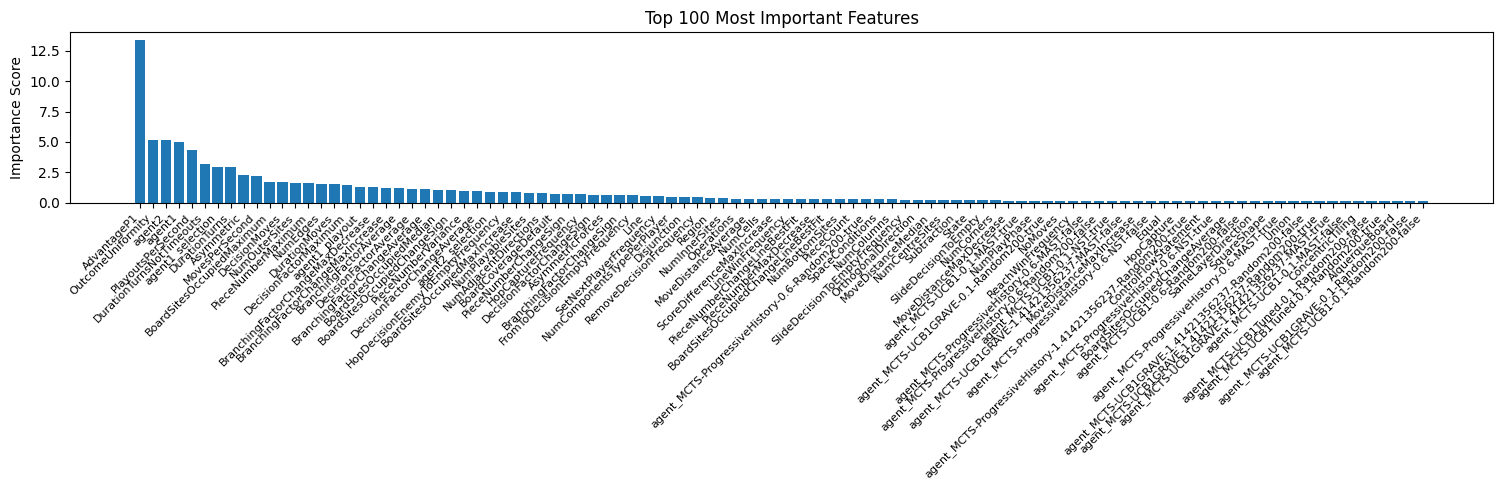

Fold 3 - RMSE: 0.42836955824613243
Fold 4
0:	learn: 0.6013880	test: 0.6113465	best: 0.6113465 (0)	total: 73.3ms	remaining: 3m 39s
50:	learn: 0.3931616	test: 0.4711929	best: 0.4711929 (50)	total: 4.04s	remaining: 3m 53s
100:	learn: 0.3585439	test: 0.4545134	best: 0.4545134 (100)	total: 8.31s	remaining: 3m 58s
150:	learn: 0.3384655	test: 0.4475000	best: 0.4475000 (150)	total: 12.5s	remaining: 3m 55s
200:	learn: 0.3240099	test: 0.4436273	best: 0.4435717 (199)	total: 16.7s	remaining: 3m 52s
250:	learn: 0.3136244	test: 0.4407981	best: 0.4407981 (250)	total: 21s	remaining: 3m 49s
300:	learn: 0.3053375	test: 0.4391795	best: 0.4391795 (300)	total: 25.2s	remaining: 3m 45s
350:	learn: 0.2984281	test: 0.4384388	best: 0.4384388 (350)	total: 29.4s	remaining: 3m 42s
400:	learn: 0.2918218	test: 0.4371712	best: 0.4371712 (400)	total: 33.8s	remaining: 3m 39s
450:	learn: 0.2859907	test: 0.4360248	best: 0.4359959 (449)	total: 38s	remaining: 3m 34s
500:	learn: 0.2806114	test: 0.4350916	best: 0.4350916 (50

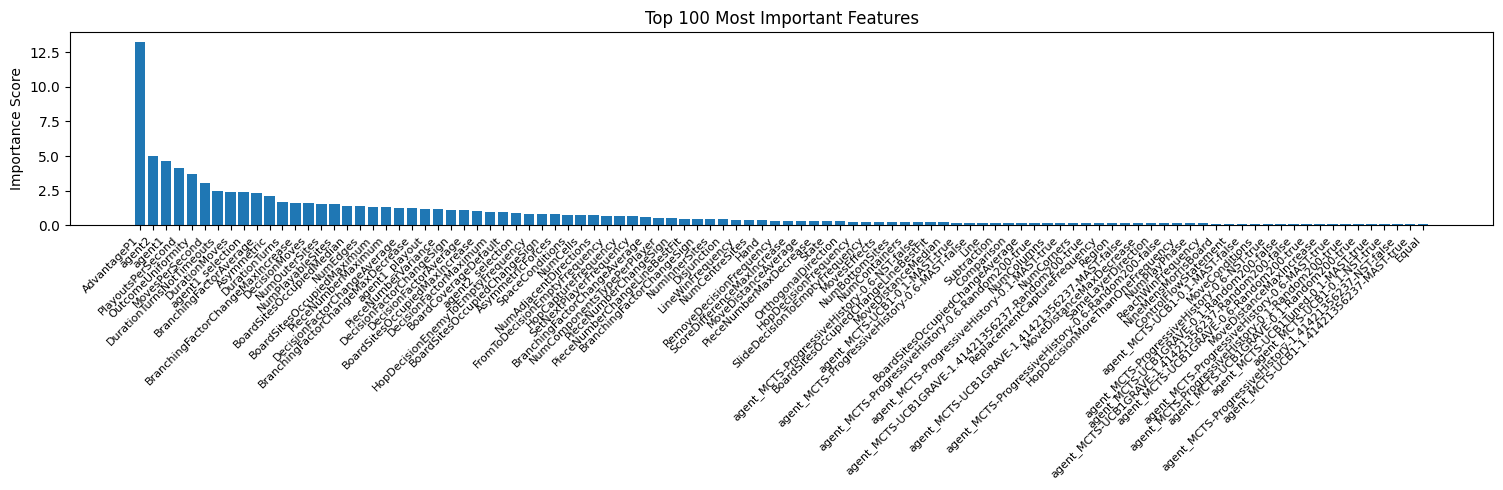

Fold 4 - RMSE: 0.42760852619123524
Fold 5
0:	learn: 0.5987004	test: 0.6186148	best: 0.6186148 (0)	total: 76.7ms	remaining: 3m 50s
50:	learn: 0.3925159	test: 0.4822474	best: 0.4822474 (50)	total: 4.06s	remaining: 3m 54s
100:	learn: 0.3554799	test: 0.4654848	best: 0.4654848 (100)	total: 8.33s	remaining: 3m 59s
150:	learn: 0.3352980	test: 0.4593983	best: 0.4593983 (150)	total: 12.6s	remaining: 3m 57s
200:	learn: 0.3217391	test: 0.4560893	best: 0.4559839 (199)	total: 16.9s	remaining: 3m 54s
250:	learn: 0.3113558	test: 0.4536961	best: 0.4536961 (250)	total: 21.2s	remaining: 3m 51s
300:	learn: 0.3033040	test: 0.4521248	best: 0.4521248 (300)	total: 25.5s	remaining: 3m 48s
350:	learn: 0.2959034	test: 0.4513739	best: 0.4513319 (344)	total: 29.8s	remaining: 3m 45s
400:	learn: 0.2896646	test: 0.4504512	best: 0.4504459 (398)	total: 34.1s	remaining: 3m 40s
450:	learn: 0.2841288	test: 0.4500053	best: 0.4499134 (446)	total: 38.4s	remaining: 3m 36s
500:	learn: 0.2792585	test: 0.4495366	best: 0.4495366

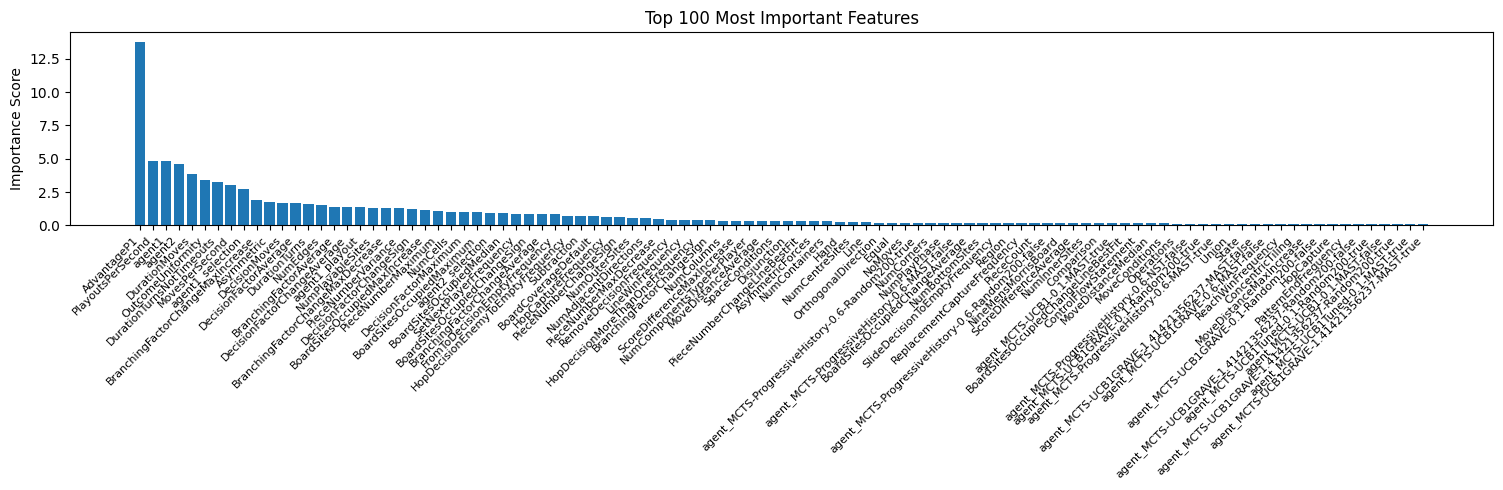

Fold 5 - RMSE: 0.4423918022067258
List of oof scores: [0.4183308778024541, 0.4311202587386601, 0.42836955824613243, 0.42760852619123524, 0.4423918022067258]
Average oof score: 0.4295642046370415


In [9]:
# call the function
trained_models2, oof2, oof_scores2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    num_folds=5,
    cv_random_state=19,
)
# save oof predictions
oof2.to_csv(path_results / 'oof_catboost_cv2.csv', index=False)

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1
0:	learn: 0.6014961	test: 0.6030358	best: 0.6030358 (0)	total: 58.9ms	remaining: 2m 56s
50:	learn: 0.3950740	test: 0.4694925	best: 0.4694925 (50)	total: 3.92s	remaining: 3m 46s
100:	learn: 0.3568248	test: 0.4514899	best: 0.4514899 (100)	total: 8.1s	remaining: 3m 52s
150:	learn: 0.3361444	test: 0.4430981	best: 0.4430981 (150)	total: 12.2s	remaining: 3m 51s
200:	learn: 0.3226279	test: 0.4390948	best: 0.4390948 (200)	total: 16.3s	remaining: 3m 47s
250:	learn: 0.3126639	test: 0.4362175	best: 0.4361998 (249)	total: 20.4s	remaining: 3m 43s
300:	learn: 0.3044133	test: 0.4340044	best: 0.4340044 (300)	total: 24.6s	remaining: 3m 40s
350:	learn: 0.2975738	test: 0.4322957	best: 0.4322957 (350)	total: 28.7s	remaining: 3m 36s
400:	learn: 0.2911181	test: 0.4312640	best: 0.4312486 (399)	total: 32.8s	remaining: 3m 32s
450:	learn: 0.2859912	test: 0.4302818	best: 0.4302818 (450)	total: 37s	remaining: 3m 29s
500:	learn: 0.2810452	test: 0.4289588	best: 0.4289588 (500)	total: 41.2s	remaining: 3m 25s


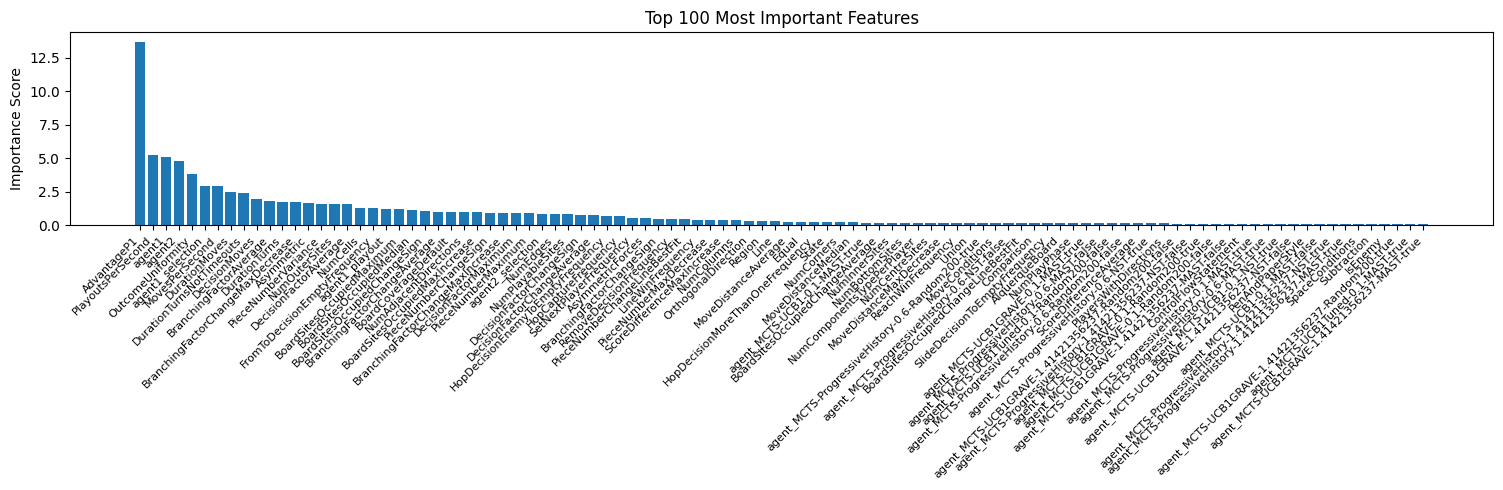

Fold 1 - RMSE: 0.4188968764408384
Fold 2
0:	learn: 0.6019996	test: 0.6061342	best: 0.6061342 (0)	total: 68.7ms	remaining: 3m 25s
50:	learn: 0.3898368	test: 0.4854286	best: 0.4854286 (50)	total: 3.94s	remaining: 3m 47s
100:	learn: 0.3540681	test: 0.4740356	best: 0.4740356 (100)	total: 8.21s	remaining: 3m 55s
150:	learn: 0.3344089	test: 0.4686881	best: 0.4686881 (150)	total: 12.4s	remaining: 3m 53s
200:	learn: 0.3188057	test: 0.4634766	best: 0.4634766 (200)	total: 16.4s	remaining: 3m 48s
250:	learn: 0.3087998	test: 0.4611581	best: 0.4611381 (249)	total: 20.7s	remaining: 3m 46s
300:	learn: 0.2993438	test: 0.4588002	best: 0.4588002 (300)	total: 24.8s	remaining: 3m 42s
350:	learn: 0.2924685	test: 0.4578434	best: 0.4578434 (350)	total: 28.9s	remaining: 3m 38s
400:	learn: 0.2862687	test: 0.4562778	best: 0.4562778 (400)	total: 33.2s	remaining: 3m 34s
450:	learn: 0.2810162	test: 0.4551441	best: 0.4551441 (450)	total: 37.4s	remaining: 3m 31s
500:	learn: 0.2762677	test: 0.4547764	best: 0.4547764 

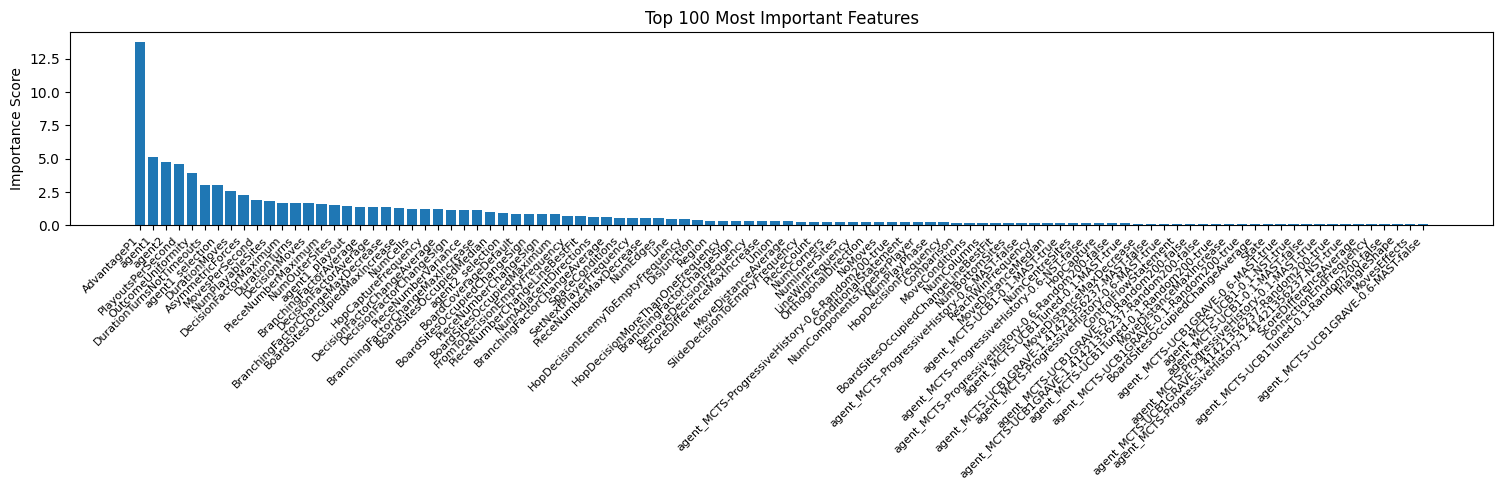

Fold 2 - RMSE: 0.4474751622706731
Fold 3
0:	learn: 0.6002023	test: 0.6070928	best: 0.6070928 (0)	total: 73.6ms	remaining: 3m 40s
50:	learn: 0.3971063	test: 0.4701608	best: 0.4701608 (50)	total: 4.04s	remaining: 3m 53s
100:	learn: 0.3604814	test: 0.4510106	best: 0.4510106 (100)	total: 8.32s	remaining: 3m 58s
150:	learn: 0.3384565	test: 0.4426570	best: 0.4426570 (150)	total: 12.5s	remaining: 3m 56s
200:	learn: 0.3246499	test: 0.4381525	best: 0.4381525 (200)	total: 16.8s	remaining: 3m 53s
250:	learn: 0.3134439	test: 0.4348297	best: 0.4348297 (250)	total: 21.1s	remaining: 3m 51s
300:	learn: 0.3042263	test: 0.4325443	best: 0.4325443 (300)	total: 25.4s	remaining: 3m 47s
350:	learn: 0.2958754	test: 0.4304669	best: 0.4304669 (350)	total: 29.8s	remaining: 3m 44s
400:	learn: 0.2897941	test: 0.4294375	best: 0.4294375 (400)	total: 34.1s	remaining: 3m 40s
450:	learn: 0.2838534	test: 0.4286576	best: 0.4286576 (450)	total: 38.3s	remaining: 3m 36s
500:	learn: 0.2785570	test: 0.4279829	best: 0.4279709 

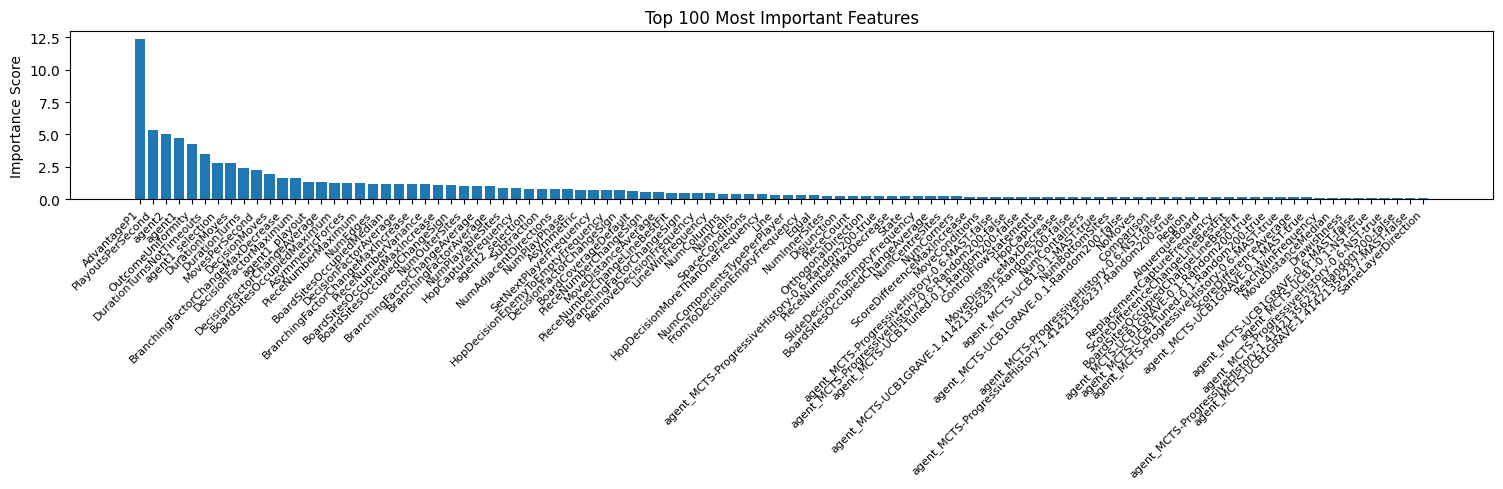

Fold 3 - RMSE: 0.41997489175847846
Fold 4
0:	learn: 0.5937594	test: 0.6381228	best: 0.6381228 (0)	total: 74.3ms	remaining: 3m 42s
50:	learn: 0.3949989	test: 0.4712015	best: 0.4712015 (50)	total: 3.96s	remaining: 3m 48s
100:	learn: 0.3592567	test: 0.4544454	best: 0.4544184 (99)	total: 8.07s	remaining: 3m 51s
150:	learn: 0.3385938	test: 0.4461446	best: 0.4461446 (150)	total: 12.3s	remaining: 3m 51s
200:	learn: 0.3257867	test: 0.4426109	best: 0.4426109 (200)	total: 16.5s	remaining: 3m 50s
250:	learn: 0.3159441	test: 0.4397667	best: 0.4397667 (250)	total: 20.7s	remaining: 3m 47s
300:	learn: 0.3062944	test: 0.4370165	best: 0.4370165 (300)	total: 24.9s	remaining: 3m 43s
350:	learn: 0.2990743	test: 0.4355200	best: 0.4355065 (348)	total: 29.1s	remaining: 3m 39s
400:	learn: 0.2930868	test: 0.4343497	best: 0.4343497 (400)	total: 33.4s	remaining: 3m 36s
450:	learn: 0.2874163	test: 0.4328394	best: 0.4328394 (450)	total: 37.5s	remaining: 3m 32s
500:	learn: 0.2819820	test: 0.4319280	best: 0.4318526 

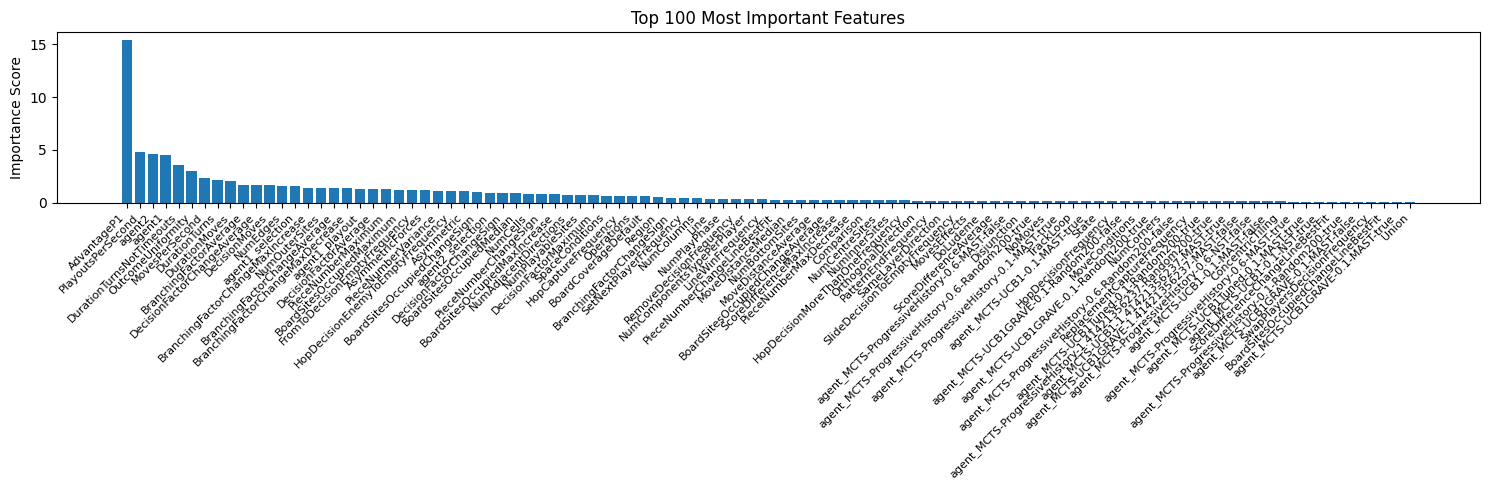

Fold 4 - RMSE: 0.421993654629464
Fold 5
0:	learn: 0.6091517	test: 0.5722540	best: 0.5722540 (0)	total: 73.3ms	remaining: 3m 39s
50:	learn: 0.3956324	test: 0.4250895	best: 0.4250895 (50)	total: 3.91s	remaining: 3m 46s
100:	learn: 0.3598657	test: 0.4092161	best: 0.4092161 (100)	total: 8.17s	remaining: 3m 54s
150:	learn: 0.3390431	test: 0.4017225	best: 0.4017225 (150)	total: 12.2s	remaining: 3m 50s
200:	learn: 0.3245162	test: 0.3969798	best: 0.3969798 (200)	total: 16.4s	remaining: 3m 47s
250:	learn: 0.3140993	test: 0.3937067	best: 0.3937067 (250)	total: 20.5s	remaining: 3m 44s
300:	learn: 0.3056725	test: 0.3916407	best: 0.3916407 (300)	total: 24.8s	remaining: 3m 42s
350:	learn: 0.2981338	test: 0.3894715	best: 0.3894637 (349)	total: 29s	remaining: 3m 38s
400:	learn: 0.2917226	test: 0.3881371	best: 0.3881371 (400)	total: 33.3s	remaining: 3m 35s
450:	learn: 0.2858519	test: 0.3864720	best: 0.3864720 (450)	total: 37.4s	remaining: 3m 31s
500:	learn: 0.2806023	test: 0.3857304	best: 0.3856897 (49

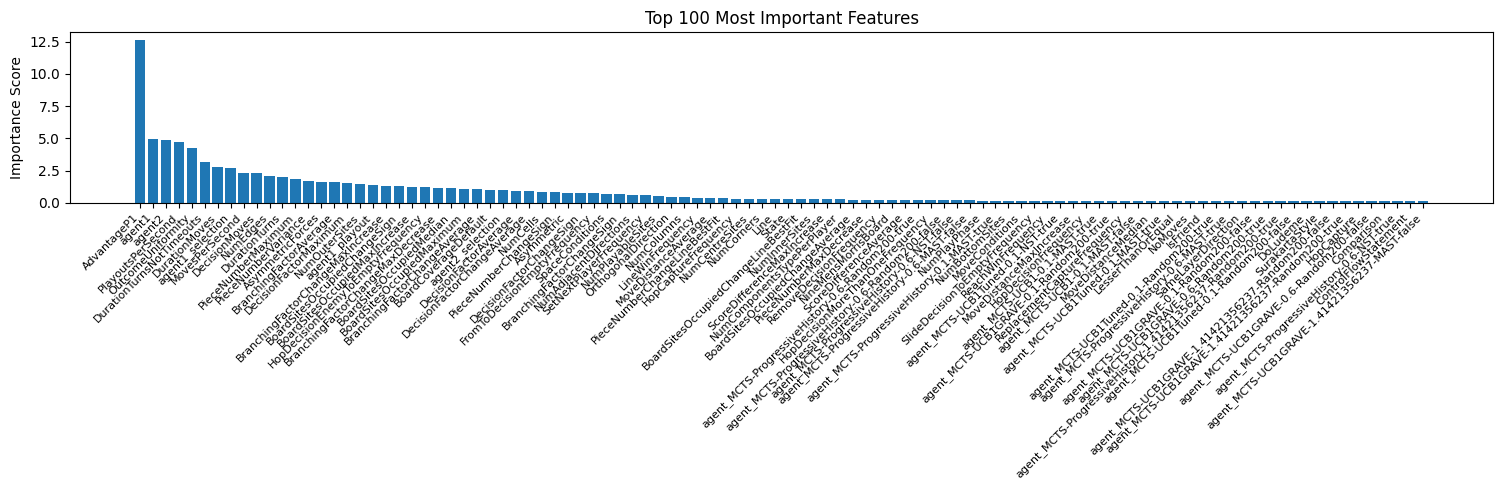

Fold 5 - RMSE: 0.37612795683576594
List of oof scores: [0.4188968764408384, 0.4474751622706731, 0.41997489175847846, 0.421993654629464, 0.37612795683576594]
Average oof score: 0.416893708387044


In [10]:
# call the function
trained_models3, oof3, oof_scores3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    num_folds=5,
    cv_random_state=23,
)
# save oof predictions
oof3.to_csv(path_results / 'oof_catboost_cv3.csv', index=False)

In [11]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]

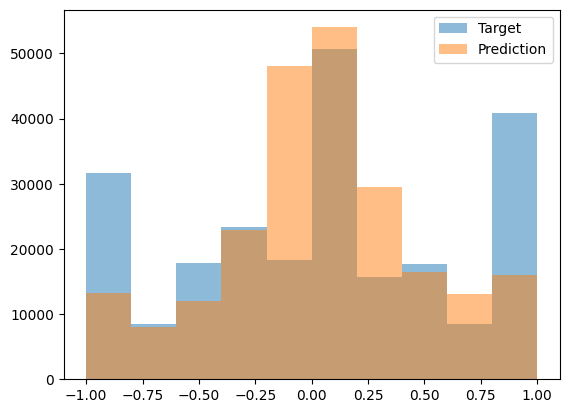

In [12]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [13]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [14]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        data=test_processed[numerical_cols + categorical_cols + text_cols],
        cat_features=categorical_cols,
        text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [15]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.135493       │
│ 233235 ┆ -0.169496      │
│ 233236 ┆ -0.034781      │
└────────┴────────────────┘

In [16]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [17]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}

with open('./catboost_predict.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***
